## Dashboard for monitoring scraping ,embedding, etc

notebooks/Dashboard.ipynb

### EDA on pdf metadata

In [118]:
import json
from pathlib import Path
import pandas as pd
from collections import Counter

#### Preparation

In [119]:
import json
import pandas as pd
from pathlib import Path
from IPython.display import display

# === Load Manifest ===
def load_manifest(path):
    rows = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                row = json.loads(line)
                rows.append(row)
            except:
                continue
    return pd.DataFrame(rows)

def summarise_manifest(df, stage_name):
    if 'doc_id' not in df:
        return pd.DataFrame({stage_name: ['No entries'], 'count': [0]})
    
    boolean_cols = [col for col in df.columns if col not in {'doc_id', 'timestamp'} and df[col].dropna().nunique() <= 2]
    counters = {}
    
    for col in boolean_cols:
        count = df[col].value_counts().to_dict()
        for k in [True, False]:
            label = f"{col}: {k}"
            counters[label] = count.get(k, 0)
    
    return pd.DataFrame(list(counters.items()), columns=[stage_name, 'count'])


#### The Scraping Dashboard

In [120]:
# === Load scraping progress ===
pdf_manifest_path = Path("../data/processed_register/pdf_manifest.jsonl")
pdf_manifest = load_manifest(pdf_manifest_path)

# === Load metadata summary ===
metadata_path = Path("../data/pdf_metadata/scraped_pdf_metadata.jsonl")
df = pd.read_json(metadata_path, lines=True)

# === Display scraping progress ===
print("📄 PDF Scraping Progress")
pdf_summary = summarise_manifest(pdf_manifest, "PDFs")
display(pdf_summary)

# === Display metadata summary ===
print(f"🧾 Metadata Extracted for {len(df)} PDFs")
display(df.tail(2))

📄 PDF Scraping Progress


,PDFs,count
0,scraped: True,727
1,scraped: False,13337
2,summarised: True,0
3,summarised: False,14064
4,chunked: True,0
5,chunked: False,14064
6,embedded: True,0
7,embedded: False,14064


🧾 Metadata Extracted for 727 PDFs


,format,title,author,creator,producer,creationDate,modDate,num_tables_detected,metadata_title,source_filename,doc_id,subject,keywords,encryption
725,PDF 1.5,__Item,Corporate Services,Microsoft Office Word,Aspose.Words for .NET 16.2.0.0,D:20170829143800Z,D:20180111090400Z,2,__Item,Item 04 Home to School Transport Appeals Updat...,kcc_cc_2018-01-23_2ca905,NaN,NaN,NaN
726,PDF 1.5,"New access and car parking, Walmer School, Dea...",Planning Department,Microsoft Office Word,Aspose.Words for .NET 16.2.0.0,D:20170918143700Z,D:20180115120600Z,0,"New access and car parking, Walmer School, Dea...",Item 05 Update on Planning Enforcement Issues.pdf,kcc_cc_2018-01-23_0a59fb,NaN,NaN,NaN


🧾 Metadata Extracted for 727 PDFs


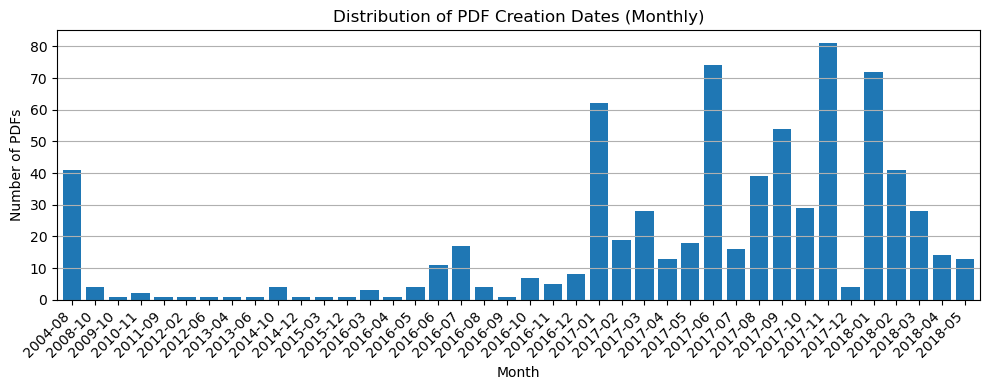

In [123]:
import matplotlib.pyplot as plt

# Parse the creation date — using only the YYYYMMDD part from the PDF metadata
df["created"] = pd.to_datetime(
    df["creationDate"].str.extract(r"D:(\d{8})")[0],
    format="%Y%m%d",
    errors="coerce"
)

# Drop NaT values for plotting
timeline = df.dropna(subset=["created"])

# Group by month or year (you can switch between these)
timeline_grouped = timeline.groupby(timeline["created"].dt.to_period("M")).size()

print(f"🧾 Metadata Extracted for {len(df)} PDFs")
# Plot the timeline
plt.figure(figsize=(10, 4))
timeline_grouped.plot(kind="bar", width=0.8)
plt.title("Distribution of PDF Creation Dates (Monthly)")
plt.xlabel("Month")
plt.ylabel("Number of PDFs")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis='y')
plt.show()

#### Missing values, etc

In [122]:
print("\n📊 Missing Values by Column")
display(df.isna().sum().sort_values(ascending=False))

print("\n📈 Metadata Field Stats")
display(df.describe(include='all'))

for col in ["author", "creator", "producer", "title"]:
    if col in df.columns:
        print(f"\n🔍 Most Common Values for {col}")
        display(df[col].value_counts().head(10))


📊 Missing Values by Column


encryption             723
keywords               719
subject                717
title                  282
author                  93
creator                 44
producer                39
modDate                  3
created                  1
format                   0
creationDate             0
num_tables_detected      0
metadata_title           0
source_filename          0
doc_id                   0
dtype: int64


📈 Metadata Field Stats


,format,title,author,creator,producer,creationDate,modDate,num_tables_detected,metadata_title,source_filename,doc_id,subject,keywords,encryption,created
count,727,445,634,683,688,727,724,727.000000,727,727,727,10,8,4,726
unique,5,81,159,27,30,666,701,NaN,82,695,727,10,7,1,NaN
top,PDF 1.5,THE REPORT,fitchd01,Microsoft Office Word,Aspose.Words for .NET 16.2.0.0,D:20040805123000Z,D:20180212164200Z,NaN,,Minutes of Previous Meeting.pdf,kcc_cc_2017-04-11_0a80ac,"Kent Utilities Engagement Sub-Committee, 27/07...","Council meetings;Government, politics and publ...",Standard V4 R4 128-bit AES,NaN
freq,651,99,110,522,481,18,2,NaN,282,21,1,1,2,4,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.962861,NaN,NaN,NaN,NaN,NaN,NaN,2016-09-18 20:05:57.024793344
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,2004-08-05 00:00:00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-31 00:00:00
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,2017-08-24 00:00:00
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-27 00:00:00
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.000000,NaN,NaN,NaN,NaN,NaN,NaN,2018-05-09 00:00:00



🔍 Most Common Values for author


author
fitchd01                 110
Planning Department       91
Fiona Treveil             86
KCC                       24
Miranda Jayne Barnard     16
GrahaA01                  13
terrys01                  11
CampbM02                   8
Lara                       7
taggs01                    6
Name: count, dtype: int64


🔍 Most Common Values for creator


creator
Microsoft Office Word             522
Acrobat PDFMaker 10.1 for Word     26
Microsoft® Word 2010               26
Neevia DC Pro - PSPDF parser       14
Microsoft® Excel® 2010             14
PScript5.dll Version 5.2.2         10
RICOH MP C6003                      9
Microsoft® Word 2016                7
Xerox WorkCentre 7835               6
Adobe InDesign CS5 (7.0)            5
Name: count, dtype: int64


🔍 Most Common Values for producer


producer
Aspose.Words for .NET 16.2.0.0                              481
Adobe PDF Library 10.0                                       33
Microsoft® Word 2010                                         26
Aspose.Words for .NET 15.7.0.0                               19
Aspose.Words for .NET 16.7.0.0                               18
Microsoft® Excel® 2010                                       14
Neevia Document Converter Pro v6.1 ( http://neevia.com )     13
RICOH MP C6003                                                9
Acrobat Distiller 10.1.16 (Windows)                           9
Microsoft® Word 2016                                          7
Name: count, dtype: int64


🔍 Most Common Values for title


title
THE REPORT                                                                           99
Minutes                                                                              86
KENT COUNTY COUNCIL                                                                  43
Discussion                                                                           26
Item No                                                                              19
Report for:                      Social Care and Health policy Overview Committee    13
SECTION G                                                                            12
By:                                                                                  12
To:                                                                                  10
Executive Decision Report                                                             6
Name: count, dtype: int64